In [ ]:
import numpy as np
import torch
import torch.nn as nn

class QLearn():
    def __init__(self, num_states, num_actions, epsilon, discount_factor, learning_rate,scale):
        self.q_table = np.zeros((scale**2, num_actions))
        self.scale = scale
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon_decay = 0.001

    # Function for epsilon-greedy action selection
    def select_action(self, state, action_space):
        if np.random.rand() < self.epsilon:
            return action_space.sample()  # Explore
        else:
            state_correct =self.get_single_state(state)
            return np.argmax(self.q_table[state_correct, :])  # Exploit

    # Function for get single state
    def get_single_state(self, state):
        new_state = []
        for position in range(len(state)):
            new_value = (state[position] + 2)
            if new_value < 0 :
              new_value = 0
            if new_value > 4 :
              new_value = 4
            new_state.append(int(round(new_value, 0)))
        single_state = int(new_state[2]/0.2   - 1 )*self.scale + int(new_state[3]/0.2) -1

        return single_state



    # Update Q-table
    def learn(self, curr_states, next_state, action, reward,episode):
        curr_states_correct =self.get_single_state(curr_states)
        next_state_correct =self.get_single_state(next_state)

        self.q_table[curr_states_correct, action] = \
                self.q_table[curr_states_correct, action] + \
                self.learning_rate * \
                (reward + self.discount_factor * np.max(self.q_table[next_state_correct, :]) - self.q_table[curr_states_correct, action])


    # Update epsilon
    def decay_epsilon(self, episode):
        self.epsilon = np.exp(-self.epsilon_decay*(episode+1))


    # Get Q-table
    def get_epsilon(self):
        return self.epsilon

    # Get Q-table
    def get_q_table(self):
        return self.q_table

In [ ]:
!pip install gymnasium
!pip install 'pettingzoo[mpe]'

In [ ]:
enum_action = { 0: "DO_nothing", 0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP" }


import gymnasium as gym
from gymnasium.utils.save_video import save_video
import numpy as np
import time


# hyperparameters
REPS = 20
EPISODES = 3000
EPSILON = 0.8
LEARNING_RATE = 0.1
DISCOUNT = 0.9
scale = 20


In [ ]:
from pettingzoo.mpe import simple_adversary_v3,simple_v3

env = simple_v3.env(max_cycles=25, continuous_actions=False,render_mode="human")
env.reset(seed=42)



In [ ]:
for agent in env.agents:
    print(agent, env.observation_space(agent).shape[0])
    observ_space_num =env.observation_space(agent).shape[0]


agent_0 4


In [ ]:
for agent in env.agents:
    print(agent, env.action_space(agent).n)
    action_space_num =env.action_space(agent).n


agent_0 5


In [ ]:
for agent in env.agents:
    num_states =env.observation_space(agent).shape[0]
    print(agent, env.observation_space(agent))
print("Observatons", env.observation_space)
for agent in env.agents:
    num_actions =env.action_space(agent).n
    print(agent, env.action_space(agent))
# Initialize Q-table
print("Initialize Q-table...")

print("Number of states", num_states)
print("Number of actions", num_actions)
q_table = np.zeros((num_states, num_actions))
print("Q-table", q_table.shape)
qlearn =QLearn(num_states, num_actions, EPSILON, DISCOUNT, LEARNING_RATE ,scale)

agent_0 Box(-inf, inf, (4,), float32)
Observatons <bound method BaseWrapper.observation_space of <pettingzoo.utils.wrappers.order_enforcing.OrderEnforcingWrapper object at 0x7cc6c3a525c0>>
agent_0 Discrete(5)
Initialize Q-table...
Number of states 4
Number of actions 5
Q-table (4, 5)


In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
total_rewards = []
for step in range(EPISODES):
    env.reset()
    termination = False
    truncation = False
    observation, reward, termination, truncation, info = env.last()

    episode_rewards = 0
    while not termination and not truncation:
        # Declare action
        action = qlearn.select_action(observation, env.action_space(env.agents[0]))
        env.step(action)
        next_observation, reward, termination, truncation, info = env.last()
        # print(next_observation, reward, termination, truncation, info)

        # Q-learning update
        qlearn.learn(observation, next_observation, action, reward,step)
        episode_rewards += reward*5
        observation = next_observation

    print(f"Episode {step}: , epsilon: {qlearn.get_epsilon()} , observ: {observation} Reward: {reward}")
    total_rewards.append(episode_rewards)
    qlearn.decay_epsilon(step +1)

env.close()


<function matplotlib.pyplot.show(close=None, block=None)>

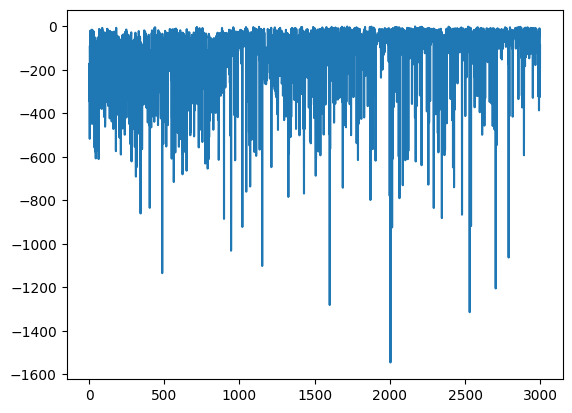

In [ ]:
import matplotlib.pyplot as plt

plt.plot(total_rewards)
plt.show

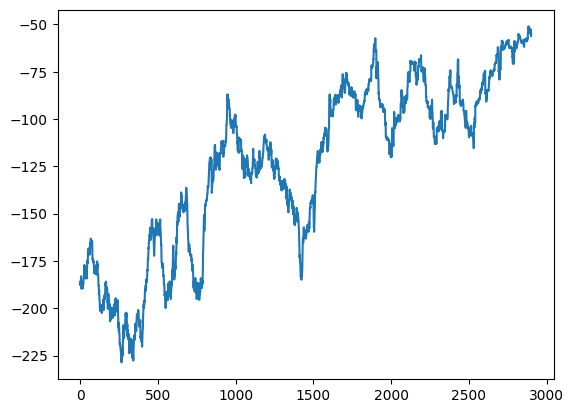

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.plot(moving_average(total_rewards, n=100))
